In [96]:
import pandas as pd
import os
current_loc = os.getcwd()
expenses = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'expenses.csv'))
gdp = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'gdp.csv'))
gns = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'goods_and_services.csv'))
index_consumer_services = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'index_consumer_services.csv'))
exchange_rate = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'pound-dollar-exchange-rate-historical-chart.csv'))
unemployment = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'unemployment.csv'))

gdp = gdp.rename(columns={'DATE': 'date'})
gns = gns.iloc[:,:8]
unemployment = unemployment.iloc[:128,:]

quarterly_data = expenses.merge(gdp, on='date', how='left').merge(gns, on='date', how='left')
monthly_data = unemployment
quarterly_data.head()

,date,expenses,GDP,net_export_goods_and_services,exports,exports_goods,exports_services,imports,imports_goods,imports_services
0,2014-01-01,"112,036",17197.738,"-510,088","2,343,602","1,593,798","749,804","2,853,690","2,360,774","492,916"
1,2014-04-01,"120,636",17518.508,"-505,404","2,395,168","1,630,163","765,006","2,900,572","2,405,659","494,914"
2,2014-07-01,"119,828",17804.228,"-489,357","2,399,191","1,635,782","763,410","2,888,549","2,392,715","495,833"
3,2014-10-01,"122,058",17912.079,"-530,751","2,376,218","1,608,074","768,144","2,906,969","2,398,103","508,866"
4,2015-01-01,"115,066",18063.529,"-526,432","2,299,045","1,524,378","774,666","2,825,476","2,330,096","495,380"


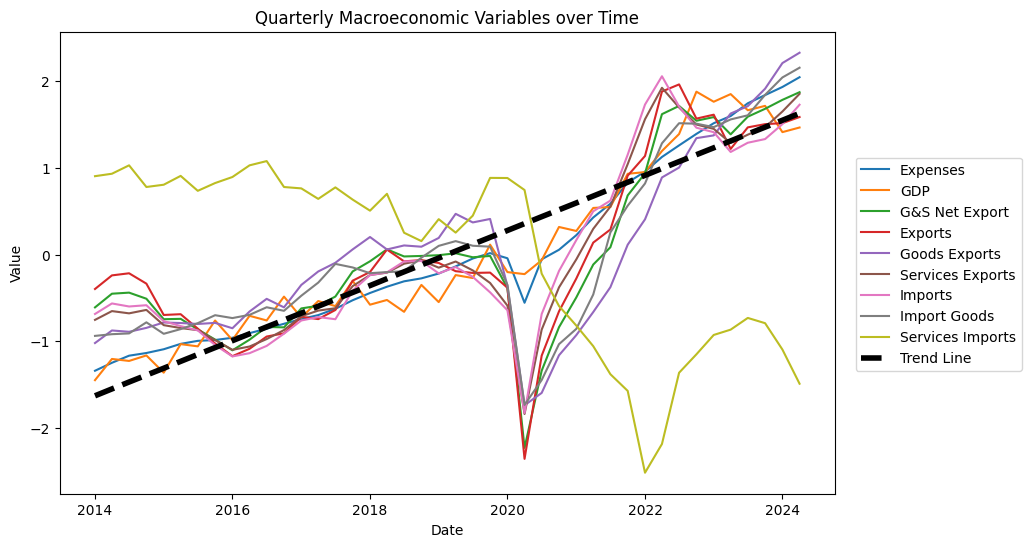

In [115]:
# Plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression

quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
covariates = quarterly_data.columns.difference(['date'])
quarterly_data = quarterly_data.dropna() # removing the dates
dates = quarterly_data['date']
columns_to_standardize = quarterly_data.columns.difference(['date'])
for column in quarterly_data.columns.difference(['date']):
    quarterly_data[column] = quarterly_data[column].astype(str).str.replace(',', '')
    quarterly_data[column] = pd.to_numeric(quarterly_data[column], errors='coerce')  # Convert back to numeric
data_to_standardize = quarterly_data[columns_to_standardize]

# Step 2: Initialize the StandardScaler
scaler = StandardScaler()

# Step 3: Fit and transform the data (standardize it)
standardized_data = scaler.fit_transform(data_to_standardize)
standardized_df = pd.DataFrame(standardized_data, columns=columns_to_standardize)
standardized_df = pd.concat([dates.reset_index(drop=True), standardized_df.reset_index(drop=True)], axis=1)
covariate_labels = ['Expenses', 'GDP', 'G&S Net Export', 'Exports', 'Goods Exports', 'Services Exports', 'Imports', 'Import Goods', 'Services Imports']

plt.figure(figsize=(10, 6))
# Plot each covariate as a line on the same graph
for i in range(len(covariates)):
    covariate_name = covariates[i]
    label = covariate_labels[i]
    plt.plot(standardized_df['date'], standardized_df[covariate_name], label=label)
    
X = np.arange(len(standardized_df)).reshape(-1, 1)  # Use index as feature
y = standardized_df["GDP"].values  # The selected covariate

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values for the trend line
trend_line = model.predict(X)

# Plot the trend line
plt.plot(standardized_df['date'], trend_line, color='black', linestyle='--', linewidth=4, label='Trend Line')

plt.title('Quarterly Macroeconomic Variables over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.25))
# Display the plot
plt.show()